In [1]:
import h5py
import json
import numpy as np
from gibson2.envs.kitchen.envs import env_factory
import matplotlib.pyplot as plt
import cv2
import io



/Users/danfeixu/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:root:Importing iGibson (gibson2 module)
INFO:root:Assets path: /Users/danfeixu/workspace/igibson/gibson2/assets
INFO:root:Dataset path: /Users/danfeixu/workspace/igibson/gibson2/dataset


In [3]:
h5_path = '/Users/danfeixu/workspace/igibson/'
f = h5py.File(h5_path, 'r')
env_args = json.loads(f["data"].attrs["env_args"])


In [4]:
env = env_factory(env_args["env_name"], **env_args["env_kwargs"], use_gui=False)


In [5]:
def get_mug_faucet(env, task_spec, state_place, state_grasp):
    env.reset()
    env.set_goal(task_specs=task_spec)
    env.reset_to(state_place)
    mug_pos = np.array(env.objects["mug"].get_position()) - np.array(env.objects["faucet_milk"].get_position())
    env.reset_to(state_grasp)
    success = env.is_success_subtasks()["fill_mug"]
    return mug_pos, success

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


In [6]:
demos = list(f["data"].keys())
mug_fill_success = []
mug_pos = []
for demo_id in demos:
    # demo_id = "demo_0"
    task_spec = f["data/{}/task_specs".format(demo_id)][0]
    states = f["data/{}/states".format(demo_id)]

    mask = f["data/{}/skill_begin".format(demo_id)][:].astype(np.bool)
    mask[-1] = True
    mask_inds = np.where(mask)[0]
    pos, success = get_mug_faucet(
        env,
        task_spec=task_spec,
        state_place=states[mask_inds[2]],
        state_grasp=states[mask_inds[3]]
    )
    mug_pos.append(pos)
    mug_fill_success.append(success)

mug_pos = np.array(mug_pos)
mug_fill_success = np.array(mug_fill_success)

TypeError: draw_wrapper() missing 1 required positional argument: 'renderer'

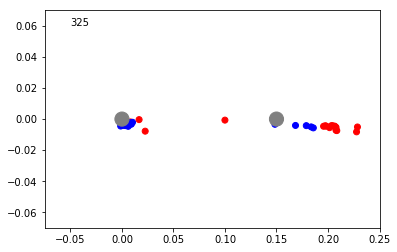

In [9]:
colors = {True: [0, 0, 1], False: [1, 0, 0]}
success_colors = np.array([colors[c] for c in mug_fill_success])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mug_pos[:, 1], mug_pos[:, 0], c=success_colors)
ax.scatter([0, 0.15], [0, 0], s=[200, 200], c='grey')
ax.set_xlim([-0.075, 0.25])
ax.set_ylim([-0.07, 0.07])
ax.text(-0.05, 0.06, "325")
fig.draw()

# arr = get_img_from_fig(fig, dpi=80)
# fig.canvas.draw()
# arr = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))

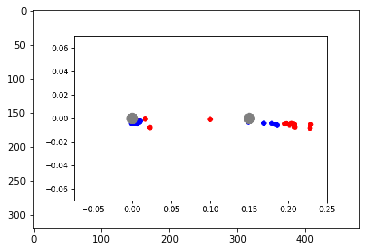

In [34]:
# plt.imshow(arr)